In [1]:
import numpy as np, pandas as pd, GPy, seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

# t-SNE structure in linear data

## by Max Zwiessele

Recently a tweet https://twitter.com/mikelove/status/738021869341839360 shook data scientists awake, showing that one of the most used dimensionality reduction techniques stochastic neighberhood embedding is 'making up' structure in a linear embedding. Their plots show incredible detailed structure in a high dimensional dataset containing only a one dimensional linear embedded input. 

Here we explore the same problem using python's implementations of tSNE and show that GPLVM and Bayesian GPLVM do not suffer from this problem.

In [2]:
n = 200
m = 40
np.random.seed(1)

In [3]:
x = np.random.uniform(-1, 1, n)
c = np.digitize(x, np.linspace(-1,1,12))-1
cols = np.asarray(sns.color_palette('spectral_r',12))[c]

### Linear embedding

The embedded linear structure. It is just a point cloud on a line betwenn -1 and 1.

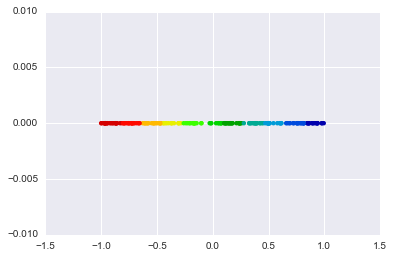

In [4]:
plt.scatter(x, np.zeros(n), c=cols, cmap='spectral_r', lw=0)

### Embed into higher dimensions

We embedd this linear point cloud in a 40 dimensional space using a 40 dimensional set of 40 orthogonal bases.

In [5]:
r = np.random.normal(0,1,[m,1])
M = np.eye(m)-2*(r.dot(r.T)/r.T.dot(r))

In [6]:
X = np.c_[x, np.zeros((n,m-1))].dot(M)

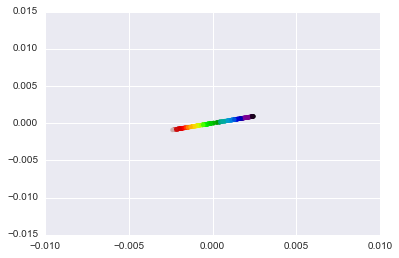

In [7]:
plt.scatter(*X[:,1:3].T, c=x, cmap='spectral', lw=0)

### PCA

The algorithm PCA finds the linear point cloud and is able to reproduce the original.

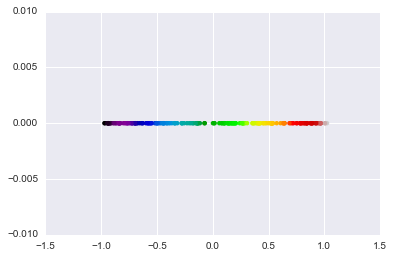

In [8]:
from sklearn.decomposition import PCA
Xpca = PCA(2).fit_transform(X)
plt.scatter(*Xpca.T, c=x, cmap='spectral', lw=0)

### scikit-learn emplementation

Careful with the scikit-learn implementation, the parameters and convergence seems to be unstable.
A too high learning rate can lead to a completely random picture. Note that a learning rate of 1000. is the standard in the library.

It seems that the scikit-learn implementation suffers from high dependence on the parameters chosen for learning. Beware of this, when using this implementation of tSNE.

In [9]:
from sklearn.manifold import TSNE

 /Users/maxz/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


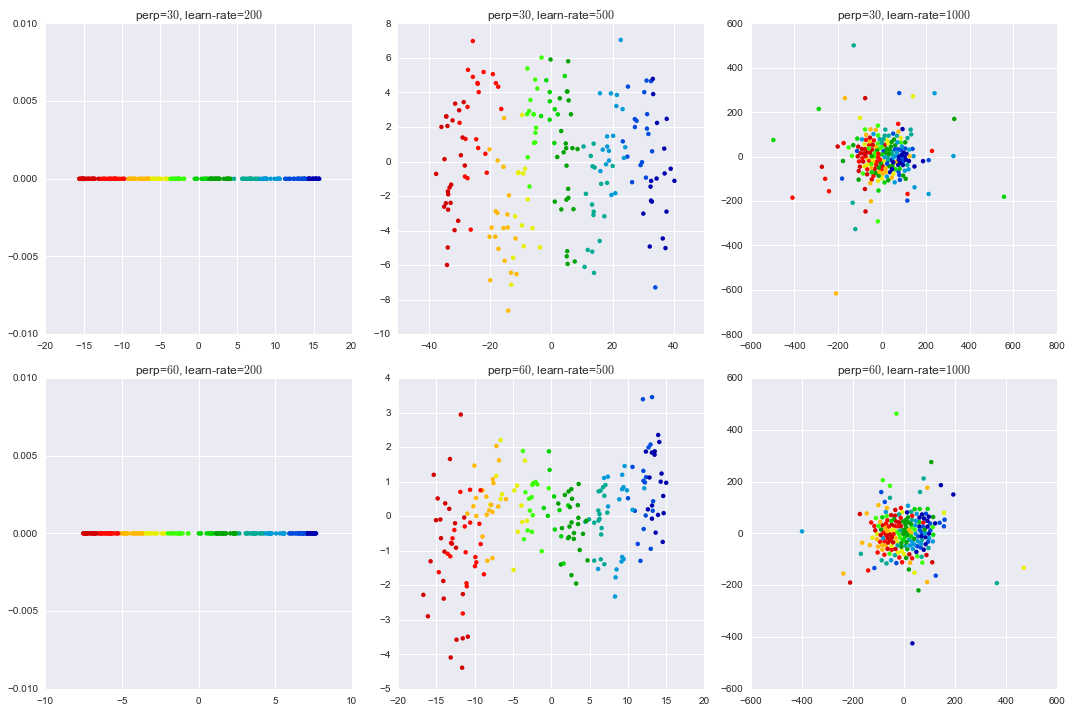

In [10]:
fig, axes = plt.subplots(2,3,tight_layout=True,figsize=(15,10))
axit = axes.flat

for perplexity in [30,60]:
    for lr in [200, 500, 1000]:
        ax = next(axit)
        Xtsne = TSNE(perplexity=perplexity, learning_rate=lr, init='pca').fit_transform(X.copy())
        ax.scatter(*Xtsne.T, c=cols, cmap='spectral', lw=0)
        ax.set_title('perp=${}$, learn-rate=${}$'.format(perplexity, lr))

### GPLVM

We show the performance of GPLVM on the dataset provided. The top right bar plot shows the sensitivity to the dimensions of the embedding. When the sensitivity is high, the dimension is used.

 /Users/maxz/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


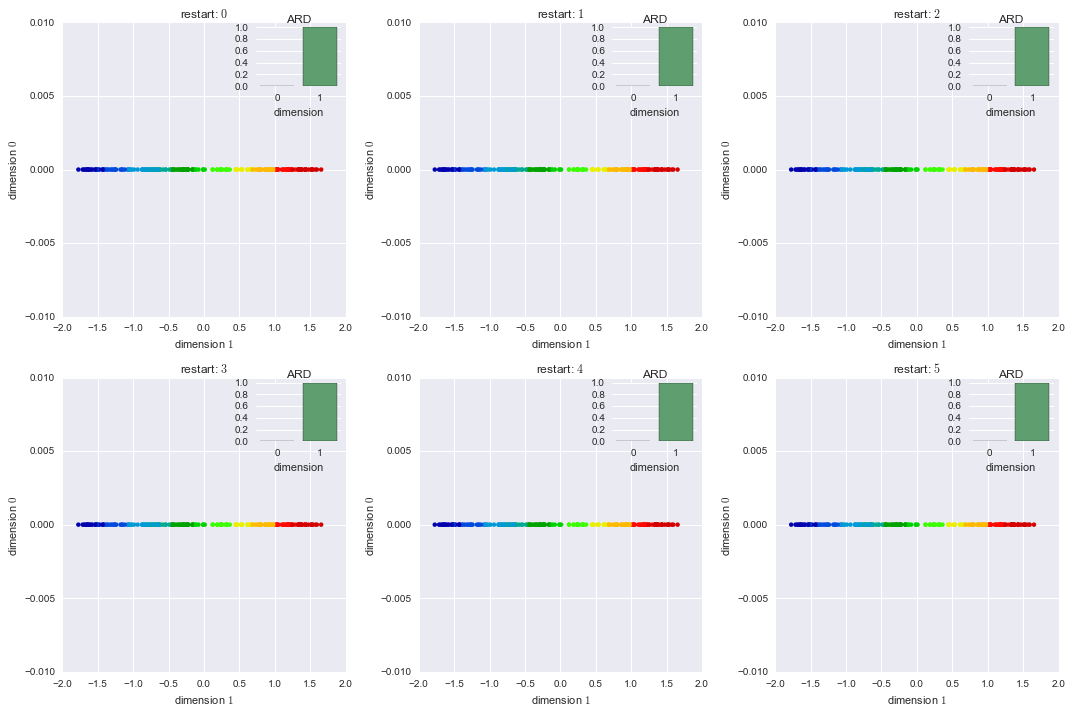

In [11]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

fig, axes = plt.subplots(2,3,tight_layout=True,figsize=(15,10))
axit = axes.flat
for lr in range(6):
    ax = next(axit)
    m = GPy.models.GPLVM(X.copy(), 2)
    m.optimize(messages=1, gtol=0, clear_after_finish=True)
    msi = m.get_most_significant_input_dimensions()[:2]
    
    is_ = m.kern.input_sensitivity().copy()
    is_ /= is_.max()
    
    XBGPLVM = m.X[:,msi] * is_[np.array(msi)]
    #m.kern.plot_ARD(ax=ax)
    ax.scatter(*XBGPLVM.T, c=cols, cmap='spectral', lw=0)
    ax.set_title('restart: ${}$'.format(lr))
    ax.set_xlabel('dimension ${}$'.format(msi[0]))
    ax.set_ylabel('dimension ${}$'.format(msi[1]))
    
    a = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height='20%', # height : 1 inch
                    loc=1)
    sns.barplot(np.array(msi), is_[np.array(msi)], label='input-sens', ax=a)
    a.set_title('ARD')
    a.set_xlabel('dimension')

### Bayesian GPLVM

Last, we want to show the ability of Bayesian GPLVM to not only find the linear imbedding, but also determine the number of necessary dimensions to embedd the data in. We start at a dimensionality of 5 and show that Bayesian GPLVM is capable of identifying one dimension as the significant one and switches off the other ones. See for that the significance of the dimensions in the top right of each subplot.

 /Users/maxz/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


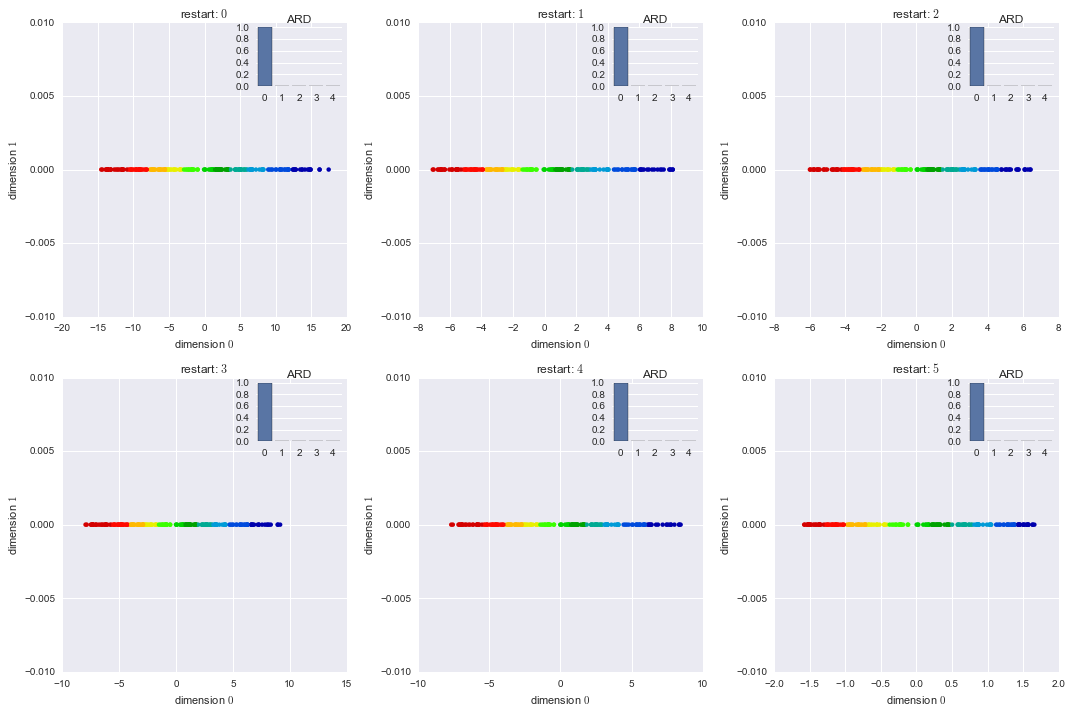

In [12]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes


fig, axes = plt.subplots(2,3,tight_layout=True,figsize=(15,10))
axit = axes.flat
for lr in range(6):
    ax = next(axit)
    m = GPy.models.BayesianGPLVM(X, 5, num_inducing=25)
    m.optimize(messages=1, gtol=0, clear_after_finish=True)
    msi = m.get_most_significant_input_dimensions()[:2]
    
    is_ = m.kern.input_sensitivity()
    is_ /= is_.max()
    
    XBGPLVM = m.X.mean[:,msi] * is_[np.array(msi)]
    #m.kern.plot_ARD(ax=ax)
    ax.scatter(*XBGPLVM.T, c=cols, cmap='spectral', lw=0)
    ax.set_title('restart: ${}$'.format(lr))
    ax.set_xlabel('dimension ${}$'.format(msi[0]))
    ax.set_ylabel('dimension ${}$'.format(msi[1]))
    
    a = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height='20%', # height : 1 inch
                    loc=1)
    sns.barplot(np.arange(m.input_dim), is_, label='input-sens', ax=a)
    a.set_title('ARD')